<a href="https://colab.research.google.com/github/pe44enka/Travel_Viz/blob/master/Travel_Viz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#install basemap
!apt-get install libgeos-3.5.0
!apt-get install libgeos-dev
!pip install https://github.com/matplotlib/basemap/archive/master.zip

Reading package lists... Done
Building dependency tree       
Reading state information... Done
E: Unable to locate package libgeos-3.5.0
E: Couldn't find any package by glob 'libgeos-3.5.0'
E: Couldn't find any package by regex 'libgeos-3.5.0'
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'apt autoremove' to remove it.
Suggested packages:
  libgdal-doc
The following NEW packages will be installed:
  libgeos-dev
0 upgraded, 1 newly installed, 0 to remove and 32 not upgraded.
Need to get 73.1 kB of archives.
After this operation, 486 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libgeos-dev amd64 3.6.2-1build2 [73.1 kB]
Fetched 73.1 kB in 1s (94.0 kB/s)
Selecting previously unselected package libgeos-dev.
(Reading database ... 145605 files and directories currently installed.)
Pr

In [0]:
import pandas as pd
from google.colab import files
import altair as alt
from vega_datasets import data
from urllib.request import Request, urlopen, urlretrieve
import json
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection
import numpy as np
import matplotlib.animation as animation
from IPython.display import HTML
from matplotlib import style
import matplotlib.ticker as ticker
import folium
from matplotlib.font_manager import FontProperties
import matplotlib



---



# US Trip

In [0]:
state_data = pd.read_csv('https://raw.githubusercontent.com/pe44enka/main/master/states.csv')
state_data.head()

State Abbr    Visit  id
0    Arizona    AZ  Visited   4
1  California   CA  Visited   6
2    Colorado   CO  Visited   8
3    Florida    FL  Visited  12
4     Hawaii    HI  Visited  15

In [0]:
states_geo = alt.topo_feature(data.us_10m.url, 'states')

selection = alt.selection_multi(fields=['State'])

states_map = alt.Chart(states_geo).mark_geoshape().encode(
    alt.Color('Visit:N',
          scale=alt.Scale(scheme='greenblue'), legend = None), tooltip='State:N'
).project(
    type='albersUsa'
).transform_lookup(
    lookup = 'id',
    from_ = alt.LookupData(state_data, 'id', ['State', 'Visit'])
).properties(
    title = "MY US TRIP MAP"
).transform_filter(selection)

states_legend = alt.Chart(state_data).mark_point().encode(
    y=alt.Y('State:N', axis=alt.Axis(orient='left'), title = "Click to see certain state"), 
            color = alt.condition(selection,
                      alt.Color('Visit:N', scale=alt.Scale(scheme='greenblue'), legend=None),
                      alt.value('whitesmoke'))
).add_selection(
    selection
)

states_map | states_legend

alt.HConcatChart(...)



---



# World Trip

In [0]:
country_data = pd.read_csv('https://raw.githubusercontent.com/pe44enka/main/master/country.csv')
country_data = country_data.drop(['Unnamed: 0'], axis = 1) #remove col with previous index
country_data.set_index('Abbr', inplace = True) #set Abbr of country as index
country_data.tail()

Country  Year  Code     Region
Abbr                                  
SGP   Singapore  2019   702       Asia
THA    Thailand  2019   764       Asia
RUS      Russia  2019   643     Europe
CAN      Canada  2019   124  N.America
RUS      Russia  2019   643     Europe

In [0]:
#save shp etc files
for ext in ['shp', 'shx', 'dbf']:
  urlretrieve('https://github.com/pe44enka/main/raw/master/all_country.' + ext, 'all_country.' + ext)

## World Trip Map

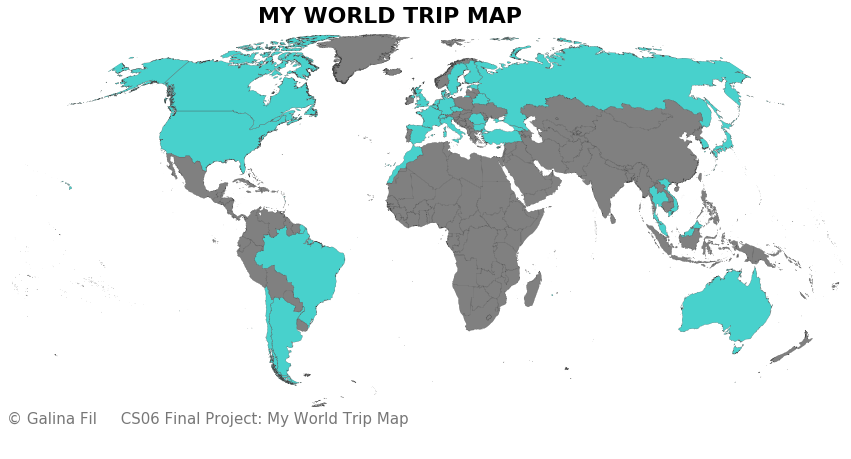

In [0]:
fig1 = plt.figure(figsize=(15,10))
ax = fig1.add_subplot(111, frame_on = False)

country_map = Basemap(projection='robin',lon_0=0)
#country_map.drawcoastlines(linewidth=0.25)
#country_map.drawcountries(linewidth=0.5)
#country_map.etopo(scale=0.5, alpha=0.5)
#country_map.fillcontinents(color='grey',lake_color='lightblue')
#country_map.drawmapboundary(fill_color='white')
country_map.drawmapboundary(color='w')

country_map.readshapefile('all_country', 'units', color='#444444', linewidth=.2)
for info, shape in zip(country_map.units_info, country_map.units):
    iso3 = info['ADM0_A3']
    if iso3 not in country_data.index:
        color = 'grey'
    else:
        color = 'mediumturquoise'
    patches = [Polygon(np.array(shape), True)]
    pc = PatchCollection(patches)
    pc.set_facecolor(color)
    ax.add_collection(pc)

ax.axhspan(0, 1000 * 1800, facecolor='w', edgecolor='w', zorder=2) #cover up Antarctica

#plt.title("MY WORLD TRIP MAP", fontsize=20, fontweight='bold')
ax.text(0.3, 1.01, 'MY WORLD TRIP MAP', size=22, fontweight='bold', weight = 800,transform=ax.transAxes)
ax.text(x=0, y=0.065, s="""© Galina Fil     CS06 Final Project: My World Trip Map""", fontsize=15, color='#777777', transform=ax.transAxes)

plt.show()



---



## World Trip History

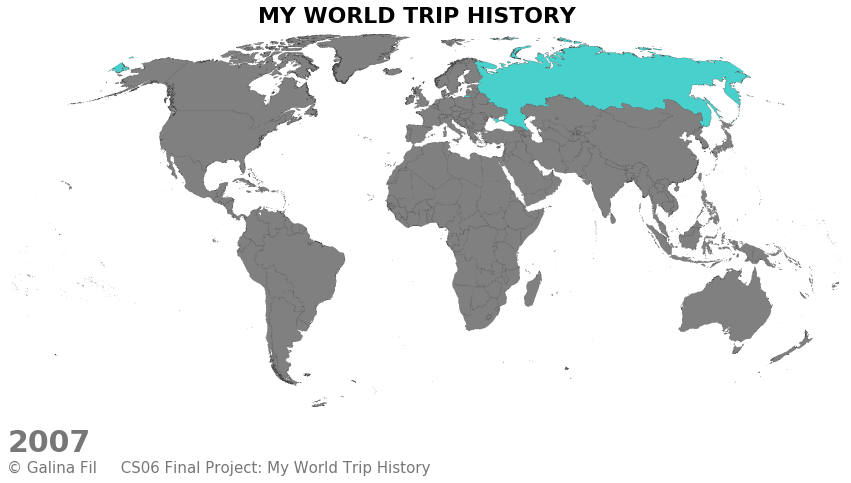

In [0]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, frame_on = False)
country_map = Basemap(projection='robin',lon_0=0)
country_map.drawmapboundary(color='w')
country_map.readshapefile('all_country', 'units', color='#444444', linewidth=.2)

def travel_history(current_year):
  country_subset = country_data[country_data.Year == current_year]
  
  #remove doubles in years
  ax.text(50,5,2019, size = 30, weight = 1000, color = 'w')
  ax.text(50,5,current_year-1, size = 30, weight = 1000, color = 'w', backgroundcolor = 'w')

  for info, shape in zip(country_map.units_info, country_map.units):
    iso3 = info['ADM0_A3']
    if iso3 not in country_subset.index:
        color = 'grey'
    else:
        color = 'mediumturquoise'
    patches = [Polygon(np.array(shape), True)]
    pc = PatchCollection(patches)
    pc.set_facecolor(color)
    ax.add_collection(pc)
  
  ax.axhspan(0, 1000 * 1800, facecolor='w', edgecolor='w', zorder=2) 

  ax.text(0.3, 1.01, 'MY WORLD TRIP HISTORY', size=22, fontweight='bold', weight = 800,transform=ax.transAxes)
  ax.text(x=0, y=-0.05, s="""© Galina Fil     CS06 Final Project: My World Trip History""", fontsize=15, color='#777777', transform=ax.transAxes)
  ax.text(50,5,current_year, size = 30, weight = 800, color = '#777777')

travel_history(2007)

In [0]:
animator1 = animation.FuncAnimation(fig, travel_history, frames = range(2007,2020), interval = 500, repeat = True)
HTML(animator1.to_jshtml())

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs


In [0]:
animator1.save('world_trip_history.mp4')
files.download('world_trip_history.mp4')

MessageError: ignored



---



## Frequently Visited Countries

In [0]:
freq_visit_country = {}
for country in country_data.Country:
  freq_visit_country[country] = freq_visit_country.get(country, 0) + 1
fvc_data = pd.DataFrame.from_dict(freq_visit_country, orient = 'index')
fvc_data = fvc_data.reset_index()
fvc_data.columns = ['Country','Frequency']

#get region from country_data to dict
region_dict = {}
for i in range(len(country_data)):
  region_dict[country_data.Country[i]] = country_data.Region[i]
#put region info to region_List to assign it later to fvc['region']
region_list = []
for country in fvc_data.Country:
  region_list.append(region_dict[country])
#creat a new col for fvs_data
fvc_data['Region'] = region_list

#sort data by freq and then by region
fvc_data = fvc_data.sort_values(by=['Frequency','Region'] )

#add color to the bars, according to region
colors = dict(zip(
    fvc_data.Region.unique(),
    ['tab:purple', 'tab:red', 'tab:blue', 'tab:orange', 'tab:green', 'tab:grey']
))

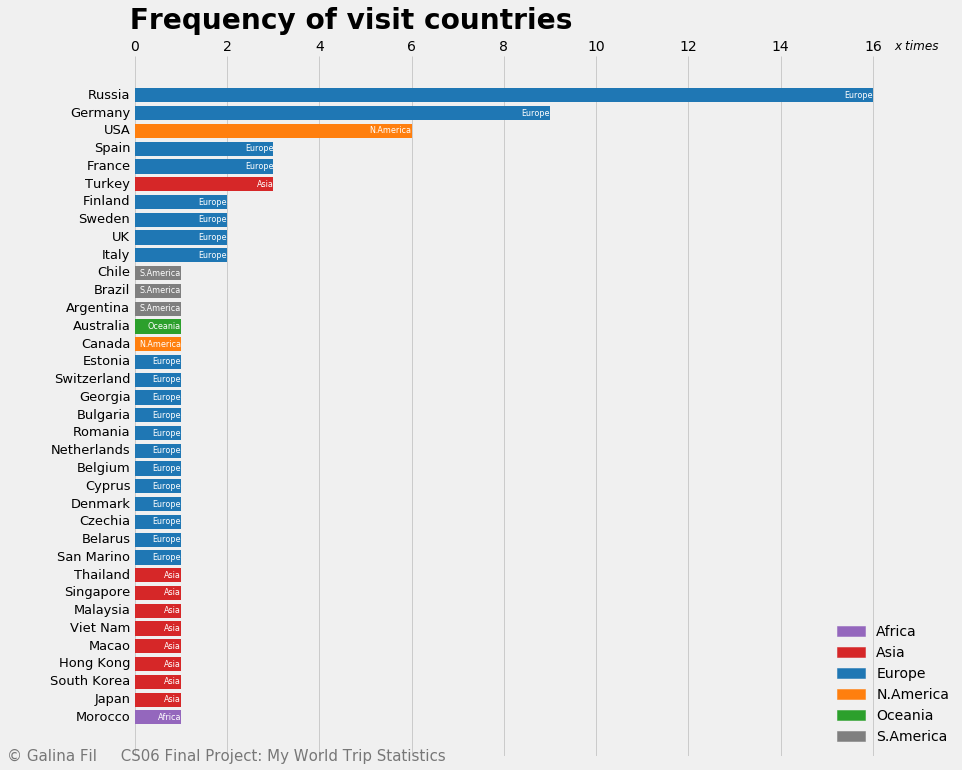

In [0]:
#frequently visited cuntries bars

with plt.style.context('fivethirtyeight'):
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.set_xlim(0,16.3)
    ax.barh(fvc_data['Country'], fvc_data['Frequency'], color = [colors[region_dict[x]] for x in fvc_data.Country])
    ax.set_facecolor('white')

    for i, (country, freq) in enumerate(zip(fvc_data['Country'], fvc_data['Frequency'])):
      ax.text(-0.1, i-0.15, country, size = 13, ha='right') #horizontalalignment (left, center, right)
      #ax.text(0, i, region_dict[country], size=6, ha='right')
      ax.text(freq, i-0.1, region_dict[country], size = 8, ha='right', color='white')
    
    #transform=ax.transAxes - transform axes dimensions: left-bottom(0,0), right-up(1,1)
    ## when animated text is at the same position
    ax.text(1.01,1.01, 'x times', transform=ax.transAxes, size = 12, style = 'italic' )
    ax.text(-0.02,1.04, ' Frequency of visit countries', fontweight = 'bold', weight = 800, transform=ax.transAxes, size = 28)
    ax.text(x=-0.17, y=-0.005, s="""© Galina Fil     CS06 Final Project: My World Trip Statistics""", fontsize=15, color='#777777', transform=ax.transAxes)

    #ax.legend()
    legend_list = []
    for region in fvc_data.Region.unique():
      patch = mpatches.Patch(color=colors[region], label=region)
      legend_list.append(patch)
    plt.legend(handles=legend_list, frameon = False, bbox_to_anchor=(1.1, 0), loc='lower right')
    
    #The formatter operates on a single tick value and returns a string to the axis by using str format method
    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
    ax.xaxis.set_ticks_position('top')

    #remove y ticks
    ax.set_yticks([])

    #add empty margin: 0.15 on x-axis, 0.03 on y-axis (for case when plot is beyond the fig)
    #ax.margins(0, 0.03)

    #add vertical lines to the plot
    ax.grid(which = 'major', axis = 'x', linestyle = '-')

    #Set whether axis ticks and gridlines are above or below most artists
    ax.set_axisbelow(True)

    #remove frame from the plot
    plt.box(False)


## Region Pie

In [0]:
#region pie

freq_visit_region = {}
for region in country_data.Region:
  freq_visit_region[region] = freq_visit_region.get(region, 0) + 1

fvr_data = pd.DataFrame.from_dict(freq_visit_region, orient = 'index')
fvr_data.reset_index(inplace = True)
fvr_data.columns = ['Region', 'Frequency']

percentage_list = []
for i in range(len(fvr_data)):
  percentage_list.append(fvr_data.Frequency[i]/sum(fvr_data.Frequency)*100)
fvr_data['Percentage'] = percentage_list


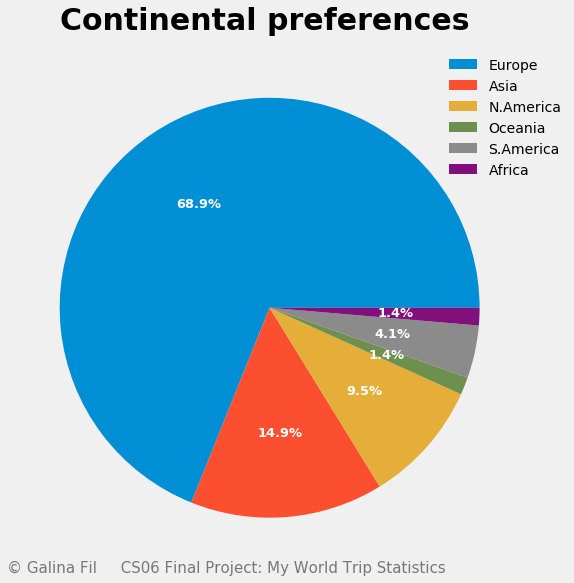

In [0]:
with plt.style.context('fivethirtyeight'):
    fig, ax = plt.subplots(figsize=(9, 9))

    #convert pct to str
    def func(pct):
      return "{:.1f}%".format(pct)
    
    pie, texts, autotexts = ax.pie(fvr_data.Percentage, autopct=lambda pct: func(pct), textprops=dict(color="w"))
    
    #legend
    region = fvr_data.Region.values
    ax.legend(pie, region, bbox_to_anchor=(1.08, 1), frameon = False, loc='upper right')
    ax.text(0.1,1.03, 'Continental preferences', fontweight='bold', weight = 800, transform=ax.transAxes, size = 30)
    ax.text(x=0, y=-0.005, s="""© Galina Fil     CS06 Final Project: My World Trip Statistics""", fontsize=15, color='#777777', transform=ax.transAxes)

    plt.setp(autotexts, size=13, weight="bold")



## New countries per year

In [0]:
#dict 'distinctive country': year
country_dict = {}
for i in range(len(country_data)):
  if not country_dict.get(country_data.Country[i], 0):
    country_dict[country_data.Country[i]] = country_data.Year[i]
  else: pass

#df out of country_dict
cy_data = pd.DataFrame.from_dict(country_dict, orient = 'index')
cy_data.reset_index(inplace = True)
cy_data.columns = ['Country', 'Year']

#dict 'year': #countries
year_dict = {}
for year in cy_data.Year:
  year_dict[year] = len(cy_data[cy_data.Year == year])
#complete empty years with 0
for i in range(2007, 2020):
 if i not in country_dict.values():
   year_dict[i] = 0

#df out of year_dict
country_per_year_data = pd.DataFrame.from_dict(year_dict, orient = 'index')
country_per_year_data.reset_index(inplace = True)
country_per_year_data.columns = ['Year', 'Quantity']
country_per_year_data = country_per_year_data.sort_values(by='Year')

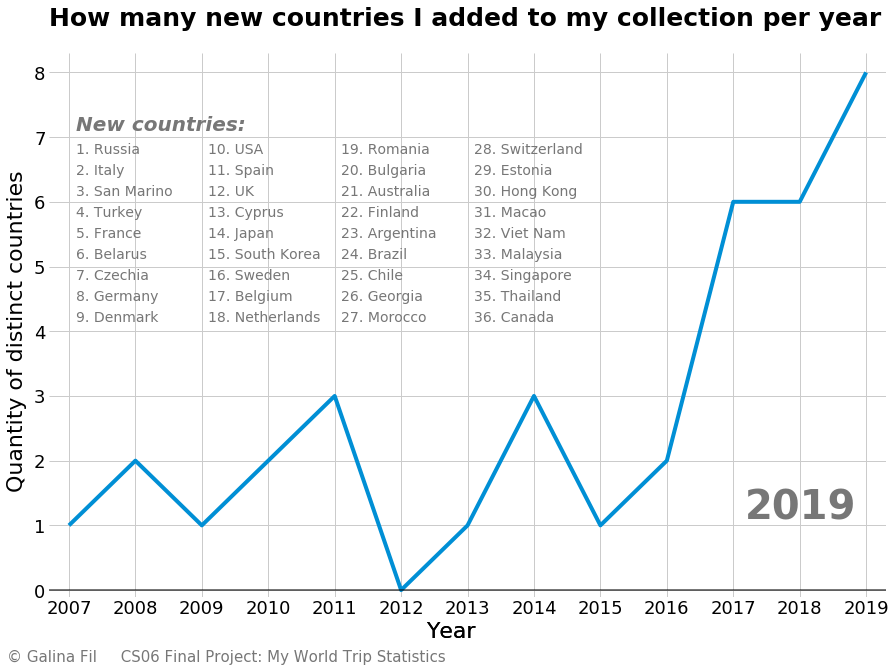

In [0]:
fig = plt.figure(figsize = (15,10))
ax = fig.add_subplot(111, frame_on = False)

def country_per_year(current_year):
  yearly_subset = country_per_year_data[country_per_year_data.Year <= current_year]
  with plt.style.context('fivethirtyeight'):
    ax.clear()
    ax.plot(yearly_subset['Year'], yearly_subset['Quantity'])

    ax.set_xlim(2006.7, 2019.3)
    ax.set_xticks(country_per_year_data.Year.values)
    ax.set_ylim(-0.1, 8.3)
    ax.axhline(y=0, color='black',alpha=0.7,linewidth=1.5)
    ax.tick_params(axis='both', which='major', labelsize=18,color ='#777777') #customize axes ticks
    ax.set_axisbelow(True)
    
    ax.text(0.45,-0.075, 'Year', transform=ax.transAxes, size = 22)
    ax.text(-0.05, 0.2, 'Quantity of distinct countries', rotation = '90', transform=ax.transAxes, size = 22)
    ax.text(0.45,-0.075, 'Year', transform=ax.transAxes, size = 22)
    ax.text(2017.18, 1.1, current_year, size=40, fontweight='bold', color = '#777777', weight = 1000)
    ax.text(2007.1, 7.1, 'New countries:', size=20, style = 'italic', fontweight='bold', color = '#777777', weight = 1000)
    ax.text(0, 1.05, 'How many new countries I added to my collection per year', size=25, fontweight='bold', weight = 800,transform=ax.transAxes)
    ax.text(x=-0.05, y=-0.12, s="""© Galina Fil     CS06 Final Project: My World Trip Statistics""", fontsize=15, color='#777777', transform=ax.transAxes)

    country_subset = cy_data[cy_data.Year <= current_year]
    count = [0 ,0, 0, 0]
    for i in range(len(country_subset)):
      if i < 9:
        ax.text(2007.1, 6.75+count[0], str(i+1) + '. ' + country_subset.Country[i], size=14, color = '#777777')
        count[0] = count[0] - 0.325
      elif i in range(9,18):
        ax.text(2009.1, 6.75+count[1], str(i+1) + '. ' + country_subset.Country[i], size=14, color = '#777777')
        count[1] = count[1] - 0.325
      elif i in range(18,27):
        ax.text(2011.1, 6.75+count[2], str(i+1) + '. ' +  country_subset.Country[i], size=14, color = '#777777')
        count[2] = count[2] - 0.325
      else: 
        ax.text(2013.1, 6.75+count[3], str(i+1) + '. ' +  country_subset.Country[i], size=14, color = '#777777')
        count[3] = count[3] - 0.325

country_per_year(2019)

In [0]:
animator = animation.FuncAnimation(fig, country_per_year, frames = range(2007,2020), interval = 500, repeat = True)
HTML(animator.to_jshtml())

In [0]:
animator.save('new_countries_per_year.mp4')
files.download('new_countries_per_year.mp4')

MessageError: ignored



---



# Flights

In [0]:
flight_data = pd.read_csv('https://raw.githubusercontent.com/pe44enka/main/master/flights.csv')
flight_data.tail()

DEPART_DATE FLIGHT_NUMBER  ...          CITY2        COUNTRY
142   16-Nov-19        UA1092  ...  San Francisco  United States
143   25-Nov-19         LH455  ...      Frankfurt        Germany
144   26-Nov-19        LH1446  ...         Moscow         Russia
145   16-Dec-19        LX1325  ...         Zurich    Switzerland
146   16-Dec-19        UA9728  ...  San Francisco  United States

[5 rows x 21 columns]

## My Flights Map

Text(0, 0.2, '© Galina Fil     CS06 Final Project: My Flights Map')

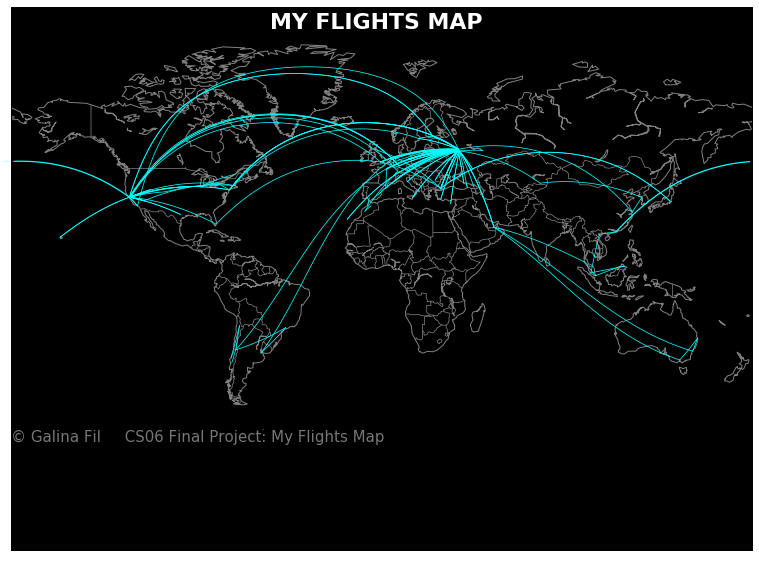

In [0]:
fig2 = plt.figure(figsize=(15,10))
ax = fig2.add_subplot(111, frame_on = False)
flight_map = Basemap(projection='mill',lon_0=0)
#flight_map.etopo(scale=0.5, alpha=0.5)
flight_map.drawcoastlines(color = 'grey', linewidth=1.0)
flight_map.drawcountries(color = 'grey', linewidth=0.75)
flight_map.fillcontinents(color='black',lake_color='black')
flight_map.drawmapboundary(fill_color='black')

for i in flight_data.index:
  line, = flight_map.drawgreatcircle(flight_data['DEPART_LON'][i], flight_data['DEPART_LAT'][i],
                                  flight_data['ARR_LON'][i], flight_data['ARR_LAT'][i], 
                                  linewidth=1.25, color='aqua')
  if i != 125:
    line.remove()
    mx,my = line.get_data()
    flight_map.plot(mx,my, color="aqua", linewidth = 0.75)

ax.axhspan(0, 1000 * 6500, facecolor='black', edgecolor='black', zorder=2) #cover up Antarctica

ax.text(0.35, 0.96, 'MY FLIGHTS MAP', size=22, fontweight='bold', weight = 800,transform=ax.transAxes, color = 'white')
ax.text(x=0, y=0.2, s="""© Galina Fil     CS06 Final Project: My Flights Map""", fontsize=15, color='#777777', transform=ax.transAxes)



---



# Statistics

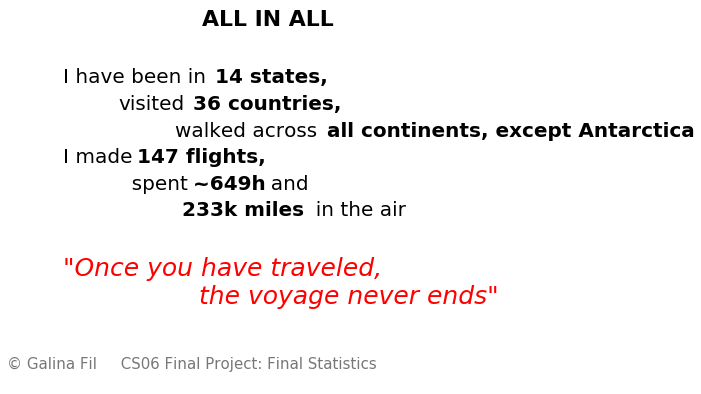

In [0]:
fig3 = plt.figure(figsize=(10,7))
ax = fig3.add_subplot(111,frame_on = False)

def trip_stat(mylist):
  ax.clear()
  ax.set_xticks([])
  ax.set_yticks([])

  ax.text(0.35, 0.95, 'ALL IN ALL', size=22, fontweight='bold', weight = 800)
  ax.text(0, 0.05, s="""© Galina Fil     CS06 Final Project: Final Statistics""", fontsize=15, color='#777777', transform=ax.transAxes)

  ax.text(0.1, 0.8, 'I have been in',size = 20 )
  ax.text(0.36, 0.8, ' {} states,'.format(str(mylist[0])), size = 20, fontweight = 'bold')
  ax.text(0.2, 0.73, 'visited',size = 20 )
  ax.text(0.32, 0.73, ' {} countries,'.format(str(mylist[1])), size = 20, fontweight = 'bold')
  ax.text(0.3, 0.66, 'walked across',size = 20 )
  ax.text(0.56, 0.66, ' {}'.format(mylist[2]), size = 20, fontweight = 'bold')
  ax.text(0.1, 0.59, 'I made',size = 20 )
  ax.text(0.22, 0.59, ' {} flights,'.format(str(mylist[3])), size = 20, fontweight = 'bold')
  ax.text(0.2, 0.52, '  spent',size = 20 )
  ax.text(0.32, 0.52, ' ~{}h'.format(str(mylist[4])), size = 20, fontweight = 'bold')
  ax.text(0.45, 0.52, '  and',size = 20 )
  ax.text(0.3, 0.45, ' {}k miles'.format(str(mylist[5])), size = 20, fontweight = 'bold')
  ax.text(0.53, 0.45, '  in the air',size = 20 )

  ax.text (0.1, 0.22, '"Once you have traveled,\n                 the voyage never ends"', style = 'italic', fontsize = 25, color = 'r')

trip_stat((14, 36, 'all continents, except Antarctica', 147, 649, 233))

In [0]:
#get num of hours out of duration of flight
hour = minute = 0
for time in pd.DatetimeIndex(flight_data.FLIGHT_DURATION).time:
  hour += time.hour
  minute += time.minute
hours = hour + round(minute / 60)

#get list of all dimensions + sort it
stat_list = [len(state_data)+1, country_per_year_data.Quantity.sum()+1, len(flight_data)+1, hours, 267]
stat_list.sort()

#get all continents
continents = list(fvr_data.Region.values)
continents.append('all continents, except Antarctica')

#get final list for animation
final_list = []
for i in range(stat_list[-1]+1):
    final_list.append([0,0, 0, 0, i, 0])

#fill up continents
start = count = 0
for i in range(0, round(len(final_list)/len(continents))*len(continents)+1, round(len(final_list)/len(continents))):
  if i:
    for j in range(start, i+1):
      if j == len(final_list): break
      final_list[j][2] = continents[count]
    start =+ i+1
    count +=1

#fill up states
start = count = 0
states = list(range(1, 15))
for i in range(0, (round(len(final_list)/len(state_data))+1)*len(state_data)+1, round(len(final_list)/len(state_data))+1):
  if i:
    for j in range(start, i+1):
      if j == len(final_list): break
      final_list[j][0] = states[count]
    start =+ i+1
    count +=1

#fil up countries
start = count = 0
countries = list(range(1, 37))
for i in range(0, int(round(len(final_list)/country_per_year_data.Quantity.sum()))*country_per_year_data.Quantity.sum()+1, int(round(len(final_list)/country_per_year_data.Quantity.sum()))):
  if i:
    for j in range(start, i+1):
      if j == len(final_list): break
      final_list[j][1] = countries[count]
    start =+ i+1
    count +=1
final_list[649][1] = 36

#fill up flights
start = count = 0
flights = list(range(1, 148))
for i in range(0, int(len(final_list)/2), int(round(len(final_list)/len(flights)))):
  if i:
    for j in range(start, i+1):
      if j == len(final_list): break
      final_list[j][3] = flights[count]
    start =+ i+1
    count +=1
for i in range(int(len(final_list)/2), len(final_list), int(round(len(final_list)/len(flights)))+1):
  if i:
    for j in range(start, i+1):
      if j == len(final_list): break
      final_list[j][3] = flights[count]
    start =+ i+1
    count +=1
for i in range(-4, 0):
  final_list[i][3] = flights[-1]

#fill up km
start = count = 0
km = list(range(1, 234))
for i in range(0, int(len(final_list)/6), int(round(len(final_list)/len(km)))-1):
  if i:
    for j in range(start, i+1):
      if count < len(km) and j < len(final_list): 
        final_list[j][5] = km[count]
    start =+ i+1
    count +=1
for i in range(int(len(final_list)/6), len(final_list), int(round(len(final_list)/len(km)))):
  if i:
    for j in range(start, i+1):
      if count < len(km) and j < len(final_list): 
        final_list[j][5] = km[count]
    start =+ i+1
    count +=1
for i in range(-4, 0):
  final_list[i][5] = km[-1]


In [0]:
#to make video of bigger size available 
matplotlib.rcParams['animation.embed_limit'] = 2**128

In [0]:
animator2 = animation.FuncAnimation(fig3, trip_stat, frames = final_list, interval = 0.1)
HTML(animator2.to_jshtml())

In [0]:
animator2.save('stat.mp4')
files.download('stat.mp4')

MessageError: ignored



---



# World City Map

In [0]:
city_data = pd.DataFrame(columns = ['City', 'Lat', 'Lon'])
cities = ['Ufa', 'Kostroma', 'Minsk', 'Brest', 'Belgorod', 'Vladimir', 'Suzdal', 'Naberegnye Chelny', 'Innopolis','Sviyazhsk',
          'San Marino', 'Florence', 'Venice', 'Sienna', 'Rome', 'Pisa', 'St. Peterburg', 'Svetlogorsk', 'Sevastopol', 
          'Simferopol', 'Evpatoria', 'Yalta', 'Feodosia', 'Novomoskovsk', 'Marmaris', 'Pamukkale', 'Krumlov', 'Dresden',
          'Rostock', 'Greiswald', 'Schwerin', 'Hamburg', 'Philadephia', 'Washington', 'Carmel-by-the-City', 'Monterey',
          'Santa Cruz', 'Oxford', 'Salisbury', 'Ayia Napa', 'Kyoto', 'Nara', 'Nikko', 'Kamakura', 'Fujinomiya', 'Bloise',
          'Versailles', 'Figueres', 'Palermo', 'Taormina', 'Gyeongju-si', 'Brugge', 'Cardiff', 'Sighisoara', 'Brasov', 
          'Constanta', 'Golden Sands', 'Brisbane', 'Belmont', 'Stanford', 'Vidnoye', 'Bakersfield', 'Fresno', 'Sacramento',
          'Redding', 'Santa Rosa', 'Pukon', 'Nikola-Lenivets', 'Granada', 'Fes', 'Ouarzazate', 'Basel', 'Tallin', 
          'Cambridge', 'Salem', 'Rockport', 'Gunnison', 'Moab', 'Flagstaff', 'South Lake Tahoe', 'Kings Beach', 
          'San Antonio', 'Dallas', 'Montreal']
lats = [54.7388, 57.7775, 53.9006, 52.0997, 50.5997, 56.1446,56.4192, 55.7185, 55.7517,55.7711,
        43.9424, 43.7696, 45.4408,43.3188, 41.9028, 43.7228, 59.9343, 54.9395, 44.6166,
        44.9521, 45.1905, 44.4909, 45.0319, 54.0109, 36.8549, 37.9137, 48.8127,51.0504,
        54.0924,54.0865, 53.6355, 53.5511, 39.9526, 38.895,36.5552, 36.6002, 
        36.9741, 51.7520, 51.0688, 34.9923, 35.0116, 34.6851, 36.7199, 35.3192,35.2221,47.5861,
        48.8014, 42.2655, 38.1157, 37.8516, 35.8562, 51.2093, 51.4816, 46.2197, 45.6580,
        44.1598, 43.2856, 27.4698, 37.5202, 37.4275, 55.5471, 35.3733, 36.7378, 38.5816,
        40.5865, 38.4404, 39.2723, 54.7519, 37.1773, 34.0181, 30.9335, 47.5596, 59.4370,
        42.3736, 42.5195, 42.6557, 38.5458, 38.5733, 35.1983, 38.9399, 39.2377,
        29.4241, 32.7767, 45.5017]
lons = [55.9721, 40.9699, 27.5590, 23.7637, 36.5983, 40.4179, 40.4536, 52.3721, 48.7473,48.6584,
        12.4578, 11.2558, 12.3155, 11.3308, 12.4964, 10.4017, 30.3351, 20.1585, 33.5254,
        34.1024, 33.3669,34.1533,35.3824, 38.2963, 28.2709, 29.1187, 14.3175,13.7373,
        12.0991, 13.3923, 11.4012, 9.9937, -75.1652, -77.0366, -121.9233, -121.8947,
        -122.0308, -1.2577, -1.7945, 34.014, 135.7681, 135.8048, 139.6982, 139.5467,138.6216, 1.3359,
        2.1301, 2.9581, 13.3615, 15.2853,129.2247, 3.2247, -3.1791, 24.7964, 25.6012,
        28.6348, 28.0406, 153.0251, -122.2758, -122.1697, 37.6986, -119.0187, -119.7871, -121.4944,
        -122.3917, -122.7141, -71.9776, 35.5998, -3.5986, -5.0078, -6.9370, 7.5886, 24.7536,
        -71.1097, -70.8967, -70.6204, -106.9253, -109.5498, -111.6513, -119.9772, -120.0266,
        -98.4936, -96.7970, -73.5673]
city_data['City'] = cities
city_data['Lat'] = lats
city_data['Lon'] = lons

In [0]:
city_map = folium.Map([51.4706,-0.461941], zoom_start = 2)
for i in range(len(flight_data)): 
  folium.Marker([flight_data.iloc[i]['DEPART_LAT'], flight_data.iloc[i]['DEPART_LON']], popup = flight_data.iloc[i]['DEPART_CITY']).add_to(city_map)
  folium.Marker([flight_data.iloc[i]['ARR_LAT'], flight_data.iloc[i]['ARR_LON']], popup = flight_data.iloc[i]['ARR_CITY']).add_to(city_map)
for i in range(len(city_data)):  
  folium.Marker([city_data.iloc[i]['Lat'], city_data.iloc[i]['Lon']], popup = city_data.iloc[i]['City']).add_to(city_map)
city_map.save('city_map.html')
city_map